# Расширенный автоэнкодер

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import mnist # библиотека MNIST
from tensorflow.keras.layers import Dense, Input,Flatten,Reshape,Lambda,BatchNormalization,Dropout,concatenate

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

numpy.uint8

In [41]:
hidden_dim = 2
num_classes = 10
batch_size = 100  # должно быть кратно 60 000 и 10 0000

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# стандартизация входных данных
x_train = x_train / 255 #0-1
x_test = x_test / 255

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes) 

In [45]:
def dropout_and_batch(x):
    return Dropout(0.3)(BatchNormalization()(x))

input_img = Input(shape=(28, 28, 1))
fl = Flatten()(input_img)
lb = Input(shape=(num_classes,))
x = concatenate([fl, lb])
x = Dense(256, activation='relu')(x)
x = dropout_and_batch(x)
x = Dense(128, activation='relu')(x)
x = dropout_and_batch(x)

z_mean2 = Dense(hidden_dim)(x)
z_log_var = Dense(hidden_dim)(x)

def noiser(args):
    global z_mean, z_log_var
    z_mean, z_log_var = args
    N = K.random_normal(shape=(batch_size, hidden_dim), mean=0., stddev=1.0)
    return K.exp(z_log_var / 2) * N + z_mean

h = Lambda(noiser, output_shape=(hidden_dim,))([z_mean2, z_log_var])

input_dec = Input(shape=(hidden_dim,))
lb_dec = Input(shape=(num_classes,))
d = concatenate([input_dec, lb_dec])
d = Dense(128, activation='elu')(d)
d = dropout_and_batch(d)
d = Dense(256, activation='elu')(d)
d = dropout_and_batch(d)
d = Dense(28*28, activation='sigmoid')(d)
decoded = Reshape((28, 28, 1))(d)

encoder = keras.Model([input_img, lb], h, name='encoder')
decoder = keras.Model([input_dec, lb_dec], decoded, name='decoder')
cvae = keras.Model([input_img, lb, lb_dec], decoder([encoder([input_img, lb]), lb_dec]), name="cvae")

z_meaner = keras.Model([input_img, lb], z_mean2)
tr_style = keras.Model([input_img, lb, lb_dec], decoder([z_meaner([input_img, lb]), lb_dec]), name='tr_style')


In [46]:
def vae_loss(x,y):
    x = K.reshape(x,shape=(batch_size,28*28))
    y = K.reshape(y,shape=(batch_size,28*28))
    loss = K.sum(K.square(x-y),axis=-1)
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = -1 )
    return (loss + kl_loss)/2/28/28

cvae.compile(optimizer='adam',loss=vae_loss)

In [47]:
cvae.fit([x_train, y_train_cat, y_train_cat], x_train, epochs=5, batch_size=batch_size, shuffle=True)

Epoch 1/5
600/600 [==============================] - 9s 7ms/step - loss: 0.0393
Epoch 2/5
600/600 [==============================] - 4s 7ms/step - loss: 0.0241
Epoch 3/5
600/600 [==============================] - 4s 7ms/step - loss: 0.0234
Epoch 4/5
600/600 [==============================] - 5s 8ms/step - loss: 0.0230
Epoch 5/5
600/600 [==============================] - 5s 8ms/step - loss: 0.0228


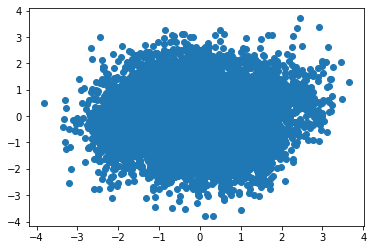

In [48]:
lb = lb_dec = y_test_cat
h = encoder.predict([x_test,lb],batch_size=batch_size)
plt.scatter(h[:,0],h[:,1])

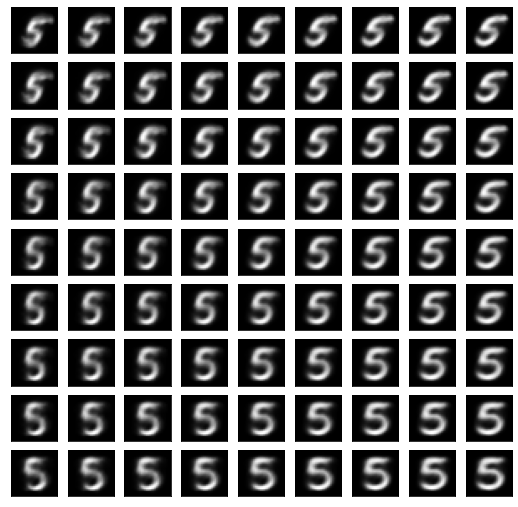

In [54]:
n = 4
total = 2*n+1
input_lbl = np.zeros((1,num_classes))
input_lbl[0,5] = 1 # выбор цифры

plt.figure(figsize=(total,total))

h = np.zeros((1,hidden_dim))
num = 1
for i in range(-n,n+1):
    for j in range(-n,n+1):
        ax = plt.subplot(total,total,num)
        num += 1
        h[0,:] = [1*i/n,1*j/n]
        img = decoder.predict([h,input_lbl])
        plt.imshow(img.squeeze(),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

<Figure size 432x288 with 0 Axes>

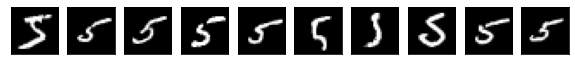

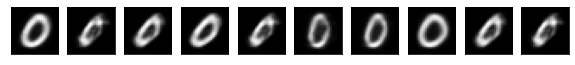

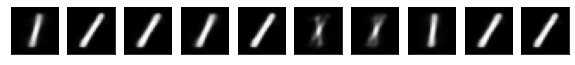

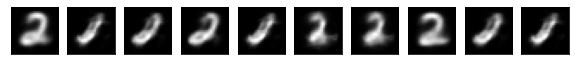

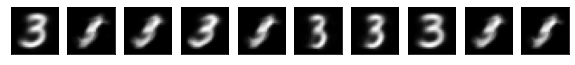

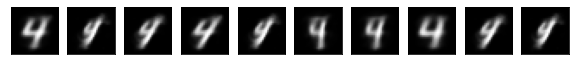

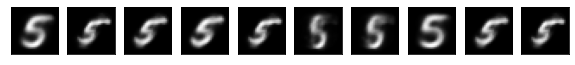

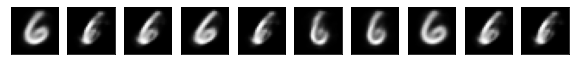

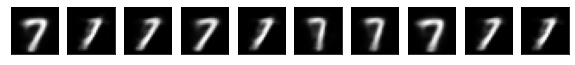

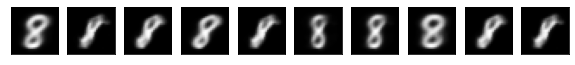

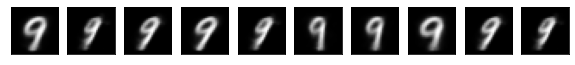

In [62]:
def plot_digits(*images):
    images  = [x.squeeze() for x in images]
    n = min([x.shape[0] for x in images])
    
    plt.figure(figsize=(n,len(images)))
    for j in range(n):
        for i in range(len(images)):
            ax = plt.subplot(len(images),n,i*n + j + 1)
            
            plt.imshow(images[i][j])
            plt.gray
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()
    
dig1 = 5
dig2 = 2
num = 10
X = x_train[y_train == dig1][:num]

lb_1 = np.zeros((num,num_classes))
lb_1[:,dig1] = 1

plt.gray()
plot_digits(X)
for i in range(num_classes):
    lb_2 = np.zeros((num,num_classes))
    lb_2[:,i] = 1
    
    Y = tr_style.predict([X,lb_1,lb_2],batch_size=num)
    plot_digits(Y)